In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from datetime import datetime, timedelta
import matplotlib.colors as mcolors
import json
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import rasterio
from cartopy.io import shapereader
from cartopy.io.shapereader import Reader
import matplotlib.dates as mdates
import seaborn as sns
from matplotlib.ticker import FixedLocator  # <-- Import corretto

from matplotlib.path import Path
import pycefeax as pfx


In [2]:
with open('input.json', 'r') as f:
    input_par = json.load(f)
savetag=input_par["save_tag"] 
output_path='output_'+savetag
# Leggi i dati
data = pd.read_csv(output_path + "/features.csv", parse_dates=['source_origin_time'])
preprocess = pd.read_csv(output_path + "/preprocess.csv", parse_dates=['Date'])




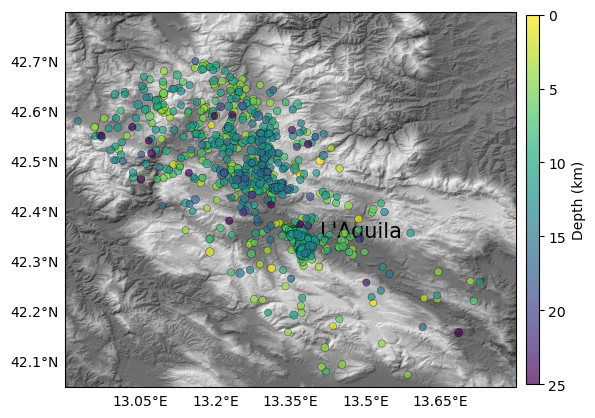

In [3]:

cata=pd.read_csv("FOREAQ_catalogue.csv",delimiter=" ")

# Define the polygon coordinates
poly = np.array([[42.2, 13.8], [42.0, 13.5], [42.6, 12.9], [42.72, 13.15], [42.63, 13.35]])

# Create a Path object for the polygon
polygon_path = Path(poly)

# Check which points are inside the polygon
points = np.column_stack((cata['Lat'], cata['Lon']))
index = polygon_path.contains_points(points)

# Filter the cata based on the index
cata = cata[index]

cata['OT'] = cata['date(y-m-d'] + ' ' + cata['h:m:s)']

cata_pfx=pfx.make_df(cata['OT'],cata['Lat'],cata['Lon'],cata['Depth(km)'],cata['Mw'])

Mmax = input_par['Mmax']
period = (datetime.fromisoformat(input_par['period']["begin"]),
            datetime.fromisoformat(input_par['period']["end"]))

cata_pfx = cata_pfx[cata_pfx['source_depth_km'] > 0]


cata_pfx.loc[:, 'source_origin_time'] = pd.to_datetime(cata_pfx['source_origin_time'])#, format='%Y/%m/%d %H:%M:%S.%f')
cata_pfx = cata_pfx[(cata_pfx['source_origin_time'] >= period[0]) & (cata_pfx['source_origin_time'] < period[1])]
cata_pfx = cata_pfx.sort_values('source_origin_time').drop_duplicates()

# === Load TIFF RGB ===
with rasterio.open("../Aquila/viz.hh_hillshade-color.tif") as src:
    r = src.read(1)
    g = src.read(2)
    b = src.read(3)
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

rgb = np.dstack((r, r, r)).astype(np.float32)
rgb /= rgb.max() if rgb.max() > 1 else 1


fig = plt.figure(figsize=(7, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([12.9, 13.8, 42.05, 42.8], crs=ccrs.PlateCarree())


ax.imshow(rgb, extent=extent, origin="upper", transform=ccrs.PlateCarree())


ax.add_feature(cfeature.BORDERS, linestyle=':')

gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

gl.xlines = False
gl.ylines = False


shapefile_path = '../ne_10m_populated_places/ne_10m_populated_places.shp'


try:
    for city in Reader(shapefile_path).records():
        lon, lat = city.geometry.x, city.geometry.y
        name = city.attributes['NAME']
        pop = city.attributes['POP_MAX']


        if 12.5 <= lon <= 14 and 42 <= lat <= 43 and pop > 1000:
            ax.plot(lon, lat, marker='o', color='black', markersize=3,
                    transform=ccrs.PlateCarree(),zorder=2)
            ax.text(lon + 0.02, lat , name,
                    fontsize=15, transform=ccrs.PlateCarree(),zorder=2)
except:
    print("City labels could not be plotted")

sorted_idx = np.argsort(cata_pfx['source_depth_km'])
sc = ax.scatter(
    cata_pfx['source_longitude_deg'].iloc[sorted_idx],
    cata_pfx['source_latitude_deg'].iloc[sorted_idx],
    c=cata_pfx['source_depth_km'].iloc[sorted_idx],
    cmap='viridis_r',
    s=cata_pfx['source_magnitude'].iloc[sorted_idx]*10+10,
    edgecolor='k',
    transform=ccrs.PlateCarree(),
    alpha=0.7,
    linewidth=.3,
    zorder=3
)
cbar = plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.02, aspect=30, shrink=0.4, )
cbar.set_label('Depth (km)', fontsize=10)
cbar.ax.invert_yaxis()

sc.set_clim(0, 25)


In [4]:
print("Dataset info:")
print(f"cata_pfx shape: {cata_pfx.shape}")
print(f"source_origin_time - min: {cata_pfx['source_origin_time'].min()}, max: {cata_pfx['source_origin_time'].max()}")
print(f"source_magnitude - min: {cata_pfx['source_magnitude'].min()}, max: {cata_pfx['source_magnitude'].max()}")
print(f"source_depth_km - min: {cata_pfx['source_depth_km'].min()}, max: {cata_pfx['source_depth_km'].max()}")


Dataset info:
cata_pfx shape: (822, 5)
source_origin_time - min: 2005-05-25 00:16:58, max: 2009-04-06 01:32:40
source_magnitude - min: 1.5, max: 5.8667
source_depth_km - min: 0.01, max: 64.85


In [5]:
cata_pfx['source_magnitude'].max()

5.8667

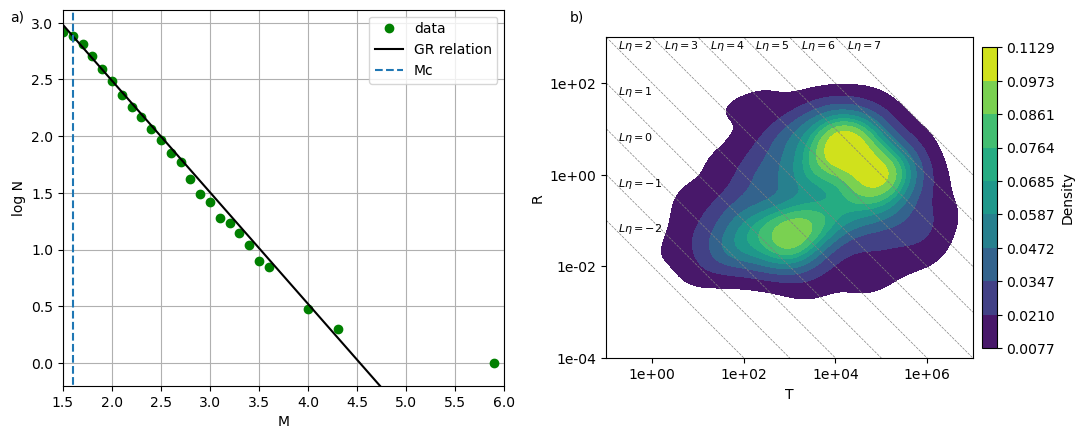

In [15]:
# Preprocessing figure
fig, axes = plt.subplots(1,2, figsize=(11, 4.5))
axes[0].annotate(text='a)',xy=(-0.12,0.97),xycoords='axes fraction')


hist, bin=np.histogram(cata_pfx['source_magnitude'],bins=np.arange(np.floor(cata_pfx['source_magnitude'].min()*10)/10-0.05,np.ceil(cata_pfx['source_magnitude'].max()*10)/10+0.15,0.1))
Mbin=(bin[:-1]+bin[1:])/2
Mbin=Mbin[hist>0]
hist=hist[hist>0]

axes[0].plot(Mbin,np.log10(np.cumsum(hist[::-1])[::-1]),'go',label='data')

xgr=np.array((cata_pfx['source_magnitude'].min(), cata_pfx['source_magnitude'].max()))
axes[0].plot(xgr,preprocess.loc[0,'agr']-xgr*preprocess.loc[0,'bgr'],'k',label='GR relation')
axes[0].vlines(x=preprocess.loc[0,'Mc'],ymin=np.log10(np.arange(cata_pfx.shape[0])+1).min()-1,ymax=np.log10(np.arange(cata_pfx.shape[0])+1).max()+1,linestyle='--',label='Mc')
axes[0].set_ylim(np.log10(np.arange(cata_pfx.shape[0])+1).min()-.2,np.log10(np.arange(cata_pfx.shape[0])+1).max()+.2)
axes[0].set_xlim(np.floor(cata_pfx['source_magnitude'].min()*2)/2,np.ceil(cata_pfx['source_magnitude'].max()*2)/2)
axes[0].set_ylabel("log N")
axes[0].set_xlabel("M")
# axes[0].axis('square')
axes[0].legend()
axes[0].grid('on')

# # 2D KDE plot

kde = sns.kdeplot(x=np.log10(preprocess["T"]), y=np.log10(preprocess["R"]), fill=True, cmap="viridis")
etas=np.arange(-2, 8, 1)
for eta in etas:
    axes[1].plot(np.array((-1, 7)), -np.array((-1, 7)) + eta, color="gray", linestyle="--", linewidth=0.5)
    if -0.2 + eta < 2:
        axes[1].text(-.75, 0.75 + eta, f"$L \\eta={eta}$", fontsize=8, color="black")
    else:
        axes[1].text(-2.75+eta, 2.75, f"$L \\eta={eta}$", fontsize=8, color="black")
axes[1].plot()
axes[1].axis('square')
axes[1].set_xlim(-1, 7)
axes[1].set_ylim(-4, 3)
# Set the ticks to show true values in scientific notation instead of logarithmic values
x_ticks = [10**i for i in range(0, 8,2)]
y_ticks = [10**i for i in range(-4, 4,2)]

axes[1].set_xticks(np.log10(x_ticks), [f"{x:.0e}" for x in x_ticks])
axes[1].set_yticks(np.log10(y_ticks), [f"{y:.0e}" for y in y_ticks])
# Add a colorbar to the KDE plot
plt.colorbar(kde.collections[0], ax=axes[1],label="Density", orientation="vertical", pad=0.02,shrink=0.8)
axes[1].set_xlabel("T")
axes[1].set_ylabel("R")
# axes[1].annotate(text='b)',xy=(0.03,0.92),xycoords='axes fraction')
axes[1].annotate(text='b)',xy=(-0.1,1.05),xycoords='axes fraction')

plt.tight_layout()

<Figure size 640x480 with 0 Axes>

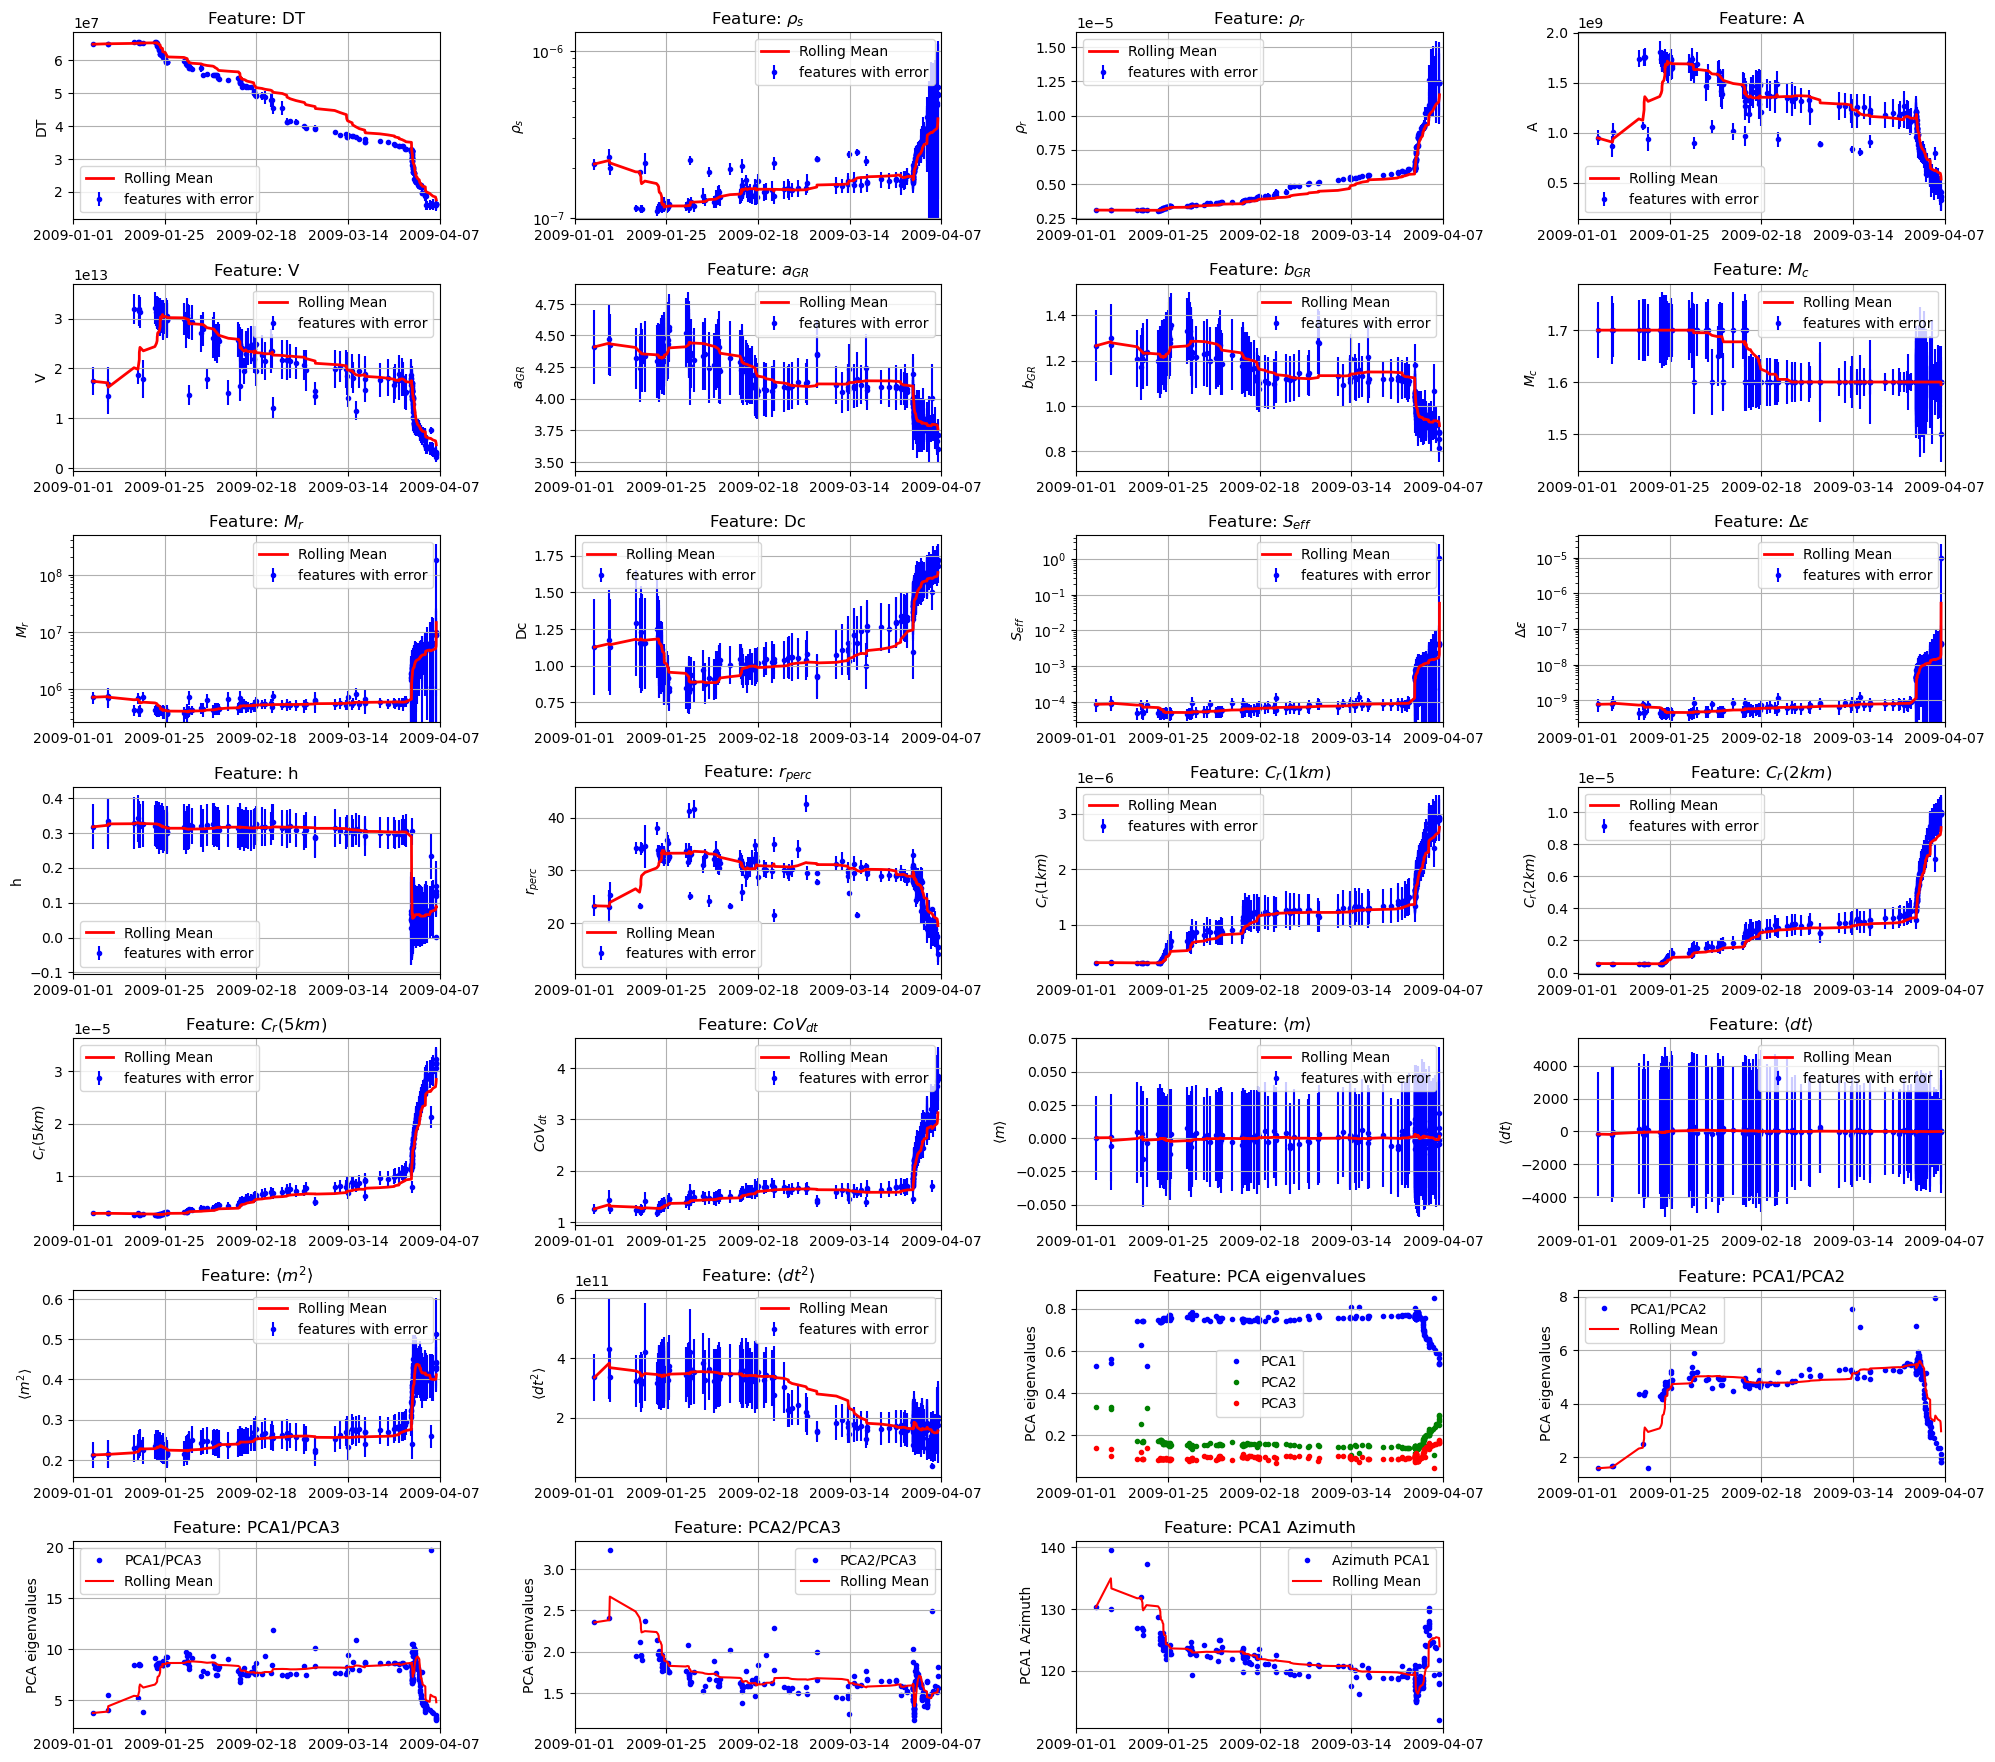

In [7]:
pfx.plot_allfeatures(data, datetime(2009,1, 1), datetime(2009, 4, 7))


C:\Users\johna\AppData\Local\Temp\ipykernel_31944\2586535614.py:34: RuntimeWarning: divide by zero encountered in divide
  k = np.sqrt(2 / (1 + z))
C:\Users\johna\AppData\Local\Temp\ipykernel_31944\2586535614.py:36: RuntimeWarning: invalid value encountered in multiply
  Y = k * y


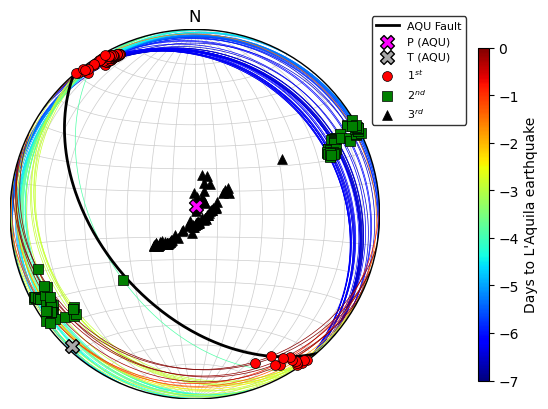

In [20]:
def schmidt_meridian(T_deg, n=300):
    T = np.deg2rad(T_deg)

    u = np.array([np.sin(T),  0, np.cos(T)])
    v = np.array([0, 1, 0])

    phi = np.linspace(-np.pi/2, np.pi/2, n)
    pts = np.outer(np.cos(phi), u) + np.outer(np.sin(phi), v)

    X, Y = [], []
    for p in pts:
        if p[2] <= 0:
            
            p = -p
        k = np.sqrt(2 / (1 + p[2]))
        X.append(k * p[0])
        Y.append(k * p[1])

    return np.array(X), np.array(Y),pts



def schmidt_parallel(P_deg,n=361):
   
    P = np.deg2rad(P_deg)
    T = np.linspace(0, 2*np.pi, n)


    x = np.cos(P) * np.sin(T)   
    z = np.cos(P) * np.cos(T)   
    y = np.sin(P) * np.ones_like(T)  


    k = np.sqrt(2 / (1 + z))
    X = k * x
    Y = k * y

    return X, Y

def project(v,neg=True):

        v = v / np.linalg.norm(v)
        if v[2] < 0:
            if neg:
                v = -v
            else:
                v = -v*np.nan
        k = np.sqrt(2 / (1 + v[2]))
        return k * v[0], k * v[1]


def trend_plunge(v):
    
    x, y, z = v
    plunge = np.arcsin(z / np.linalg.norm(v))  # rad
    trend = np.arctan2(x, y)  
    trend = trend % (2*np.pi)
    return np.degrees(trend), np.degrees(plunge)

def PT_axes(strike, dip, rake):
    
    strike = np.deg2rad(strike)
    dip    = np.deg2rad(dip)
    rake   = np.deg2rad(rake)


    n_x = -np.sin(dip) * np.sin(strike)
    n_y =  np.sin(dip) * np.cos(strike)
    n_z = -np.cos(dip)


    s_x =  np.cos(rake) * np.cos(strike) + np.sin(rake) * np.cos(dip) * np.sin(strike)
    s_y =  np.cos(rake) * np.sin(strike) - np.sin(rake) * np.cos(dip) * np.cos(strike)
    s_z =  -np.sin(rake) * np.sin(dip)


    n = np.array([n_x, n_y, n_z])


    s = np.array([s_x, s_y, s_z])


    P = n - s
    T = n + s
    P /= np.linalg.norm(P)
    T /= np.linalg.norm(T)


    P_trend, P_plunge = trend_plunge(P)
    T_trend, T_plunge = trend_plunge(T)

    return {
        'P_vector': P,
        'T_vector': T,
        'P_trend': P_trend,
        'P_plunge': P_plunge,
        'T_trend': T_trend,
        'T_plunge': T_plunge
    }


fig, ax = plt.subplots()

#data selection
t_AQ = datetime(2009, 4, 6) + timedelta(hours=2)
t_end = t_AQ
t_start = t_end - timedelta(days=7)
colors = plt.cm.jet(np.linspace(0, 1, 1000))


#draw projection grid
for P in range(-90,90, 10):
    X, Y = schmidt_parallel(P)
    ax.plot(X, Y, color='0.8', linewidth=0.5,zorder=0)


for T in range(0, 180, 10):
    X, Y, pts = schmidt_meridian(T)
    ax.plot(X, Y, color='0.8', linewidth=0.5,zorder=0)
legends_done = False
focmec=[139,	48, -87]  # strike, dip, rake


# Projecting focal mechanism (focmec: strike, dip, rake)
strike, dip, rake = focmec
# Convert to radians
strike_rad = np.deg2rad(strike)
dip_rad = np.deg2rad(dip)
rake_rad = np.deg2rad(rake)

v1=np.array([np.sin(strike_rad),np.cos(strike_rad),0])
v2=np.array([np.cos(strike_rad)*np.cos(dip_rad),-np.sin(strike_rad)*np.cos(dip_rad),np.sin(dip_rad)])
theta = np.linspace(0, np.pi*2, 300)
ellipse = ( np.cos(theta)[:,None] * v1 +
                    np.sin(theta)[:,None] * v2)

XY = np.array([project(v,neg=False) for v in ellipse])
ax.plot(XY[:,0], XY[:,1], color='k',zorder=2,linewidth=2,label='AQU Fault')


# Plot P and T axes

res = PT_axes(strike=strike, dip=dip, rake=rake)
P_vec = res['P_vector']
T_vec = res['T_vector']

p_x, p_y = project(P_vec,neg=True)
t_x, t_y = project(T_vec,neg=True)
# Plot PCA in time
if P_vec[2]<0:
    ax.scatter(p_x, p_y, s=100, color='magenta', marker='X', label='P (AQU)', zorder=3, linewidths=1, edgecolors='k')
    ax.scatter(t_x, t_y, s=100, color='darkgray', marker='X', label='T (AQU)', zorder=3, linewidths=1, edgecolors='k')
else:
    ax.scatter(p_x, p_y, s=100, color='magenta', marker='o', label='P (AQU)', zorder=3, linewidths=1, edgecolors='k')
    ax.scatter(t_x, t_y, s=100, color='darkgray', marker='o', label='T (AQU)', zorder=3, linewidths=1, edgecolors='k')
for i, row in data.iterrows():
    if row['source_origin_time'] > t_start and row['source_origin_time'] < t_end  :
       
       
        normtime = (row['source_origin_time']-t_start ) / (t_end - t_start )

        #eigenvectors
        V = np.column_stack((np.array([row['PCA_1x'], row['PCA_1y'], row['PCA_1z']]),
                            np.array([row['PCA_2x'], row['PCA_2y'], row['PCA_2z']]),
                            np.array([row['PCA_3x'], row['PCA_3y'], row['PCA_3z']])))

        e1, e2, e3 = V.T

        # 

        theta = np.linspace(0, np.pi*2, 300)
        ellipse = ( np.cos(theta)[:,None] * e1 +
                    np.sin(theta)[:,None] * e2)


        
        #project eigen-ellipse
        XY = np.array([project(v,neg=False) for v in ellipse])
        ax.plot(XY[:,0], XY[:,1], color=colors[int(normtime * 999)],zorder=1,linewidth=.5)

        #project eigenvectors
        for e, c, lab,mrk in zip([e1,e2,e3], ['r','g','k'], [r'$1^{st}$',r'$2^{nd}$',r'$3^{rd}$'],['o','s','^']):
            x,y = project(e,neg=True)

            if not legends_done:
                ax.scatter(x,y,s=50,color='k',label=lab,zorder=2,facecolors=c,marker=mrk,linewidths=0.5)
                
            else:
                ax.scatter(x,y,s=50,color='k',label=None,zorder=2,facecolors=c,marker=mrk,linewidths=0.5)
        legends_done = True


R = np.sqrt(2)



circle = plt.Circle((0, 0), R, fill=False, linewidth=1)
ax.add_artist(circle)

ax.set_aspect('equal')
ax.set_xlim(-R, R)
ax.set_ylim(-R, R)
ax.axis('off')
for line in ax.lines:
    line.set_clip_path(circle)
plt.title("N")
cax=ax.inset_axes([0.05, 0.05, 1.2, 0.9])
cax.axis('off')
sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmax=0, vmin=-(t_end - t_start ).total_seconds()/3600/24))
sm.set_array([])
cbar = plt.colorbar(sm, ax=cax, orientation='vertical', pad=2, aspect=30, shrink=1)
cbar.set_label('Days to L\'Aquila earthquake', fontsize=10)

plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1.05), fontsize=8, edgecolor='black')
plt.show()
